MODEL- VGG16

In [2]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf


from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [5]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")

In [6]:
folds.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
df = pd.DataFrame(folds.iloc[:7909])
df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [8]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


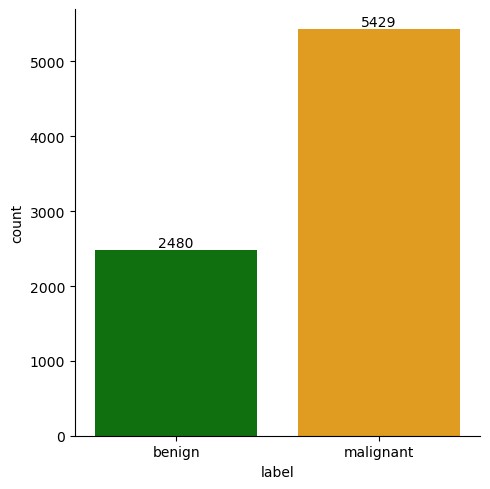

In [9]:
# Striping any leading/trailing whitespace from the below labels
df['label'] = df['label'].str.strip()

# Creating the plot with counts
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)

# This code is to ensure that the bar data labels is served to all the bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# visualization of the plot
plt.show()

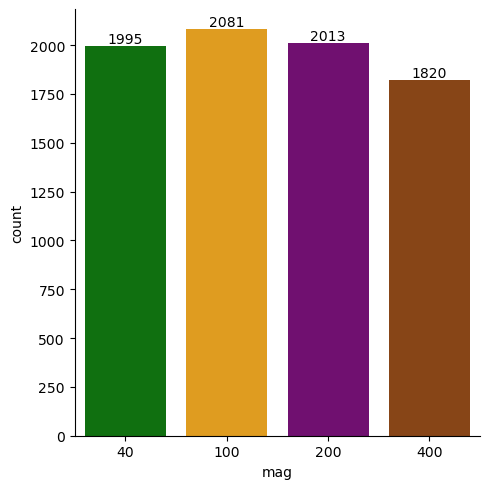

In [10]:
g = sns.catplot(x="mag", data=df, kind="count", hue="mag", palette=['green', 'orange', 'purple', "#9a4204"], legend=False)

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# Show the plot
plt.show()

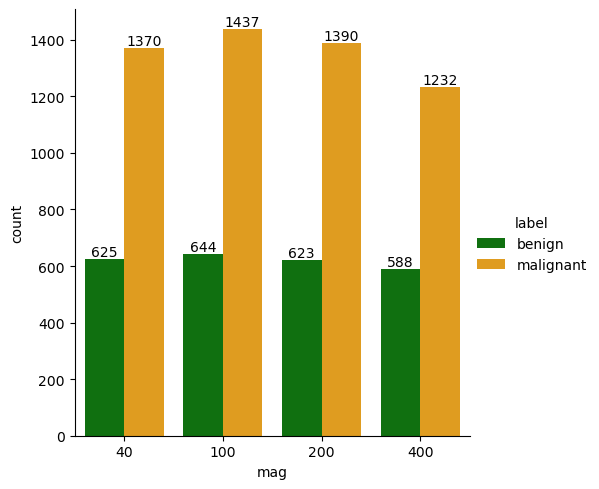

In [11]:
g = sns.catplot(x="mag", data=df, hue="label", kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c)
plt.show()

Split the data and load images

In [13]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [14]:
df

,fold,mag,grp,filename,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0
...,...,...,...,...,...,...
7904,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7905,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7906,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1
7907,1,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,1


In [15]:
random_state = 42

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [17]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(( "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_test, y_test))

Build and evaluate a model
Created model: VGG-16 + fully-connected layer.

In [77]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [79]:
from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [81]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

In [83]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

2024-07-09 23:34:37.821135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


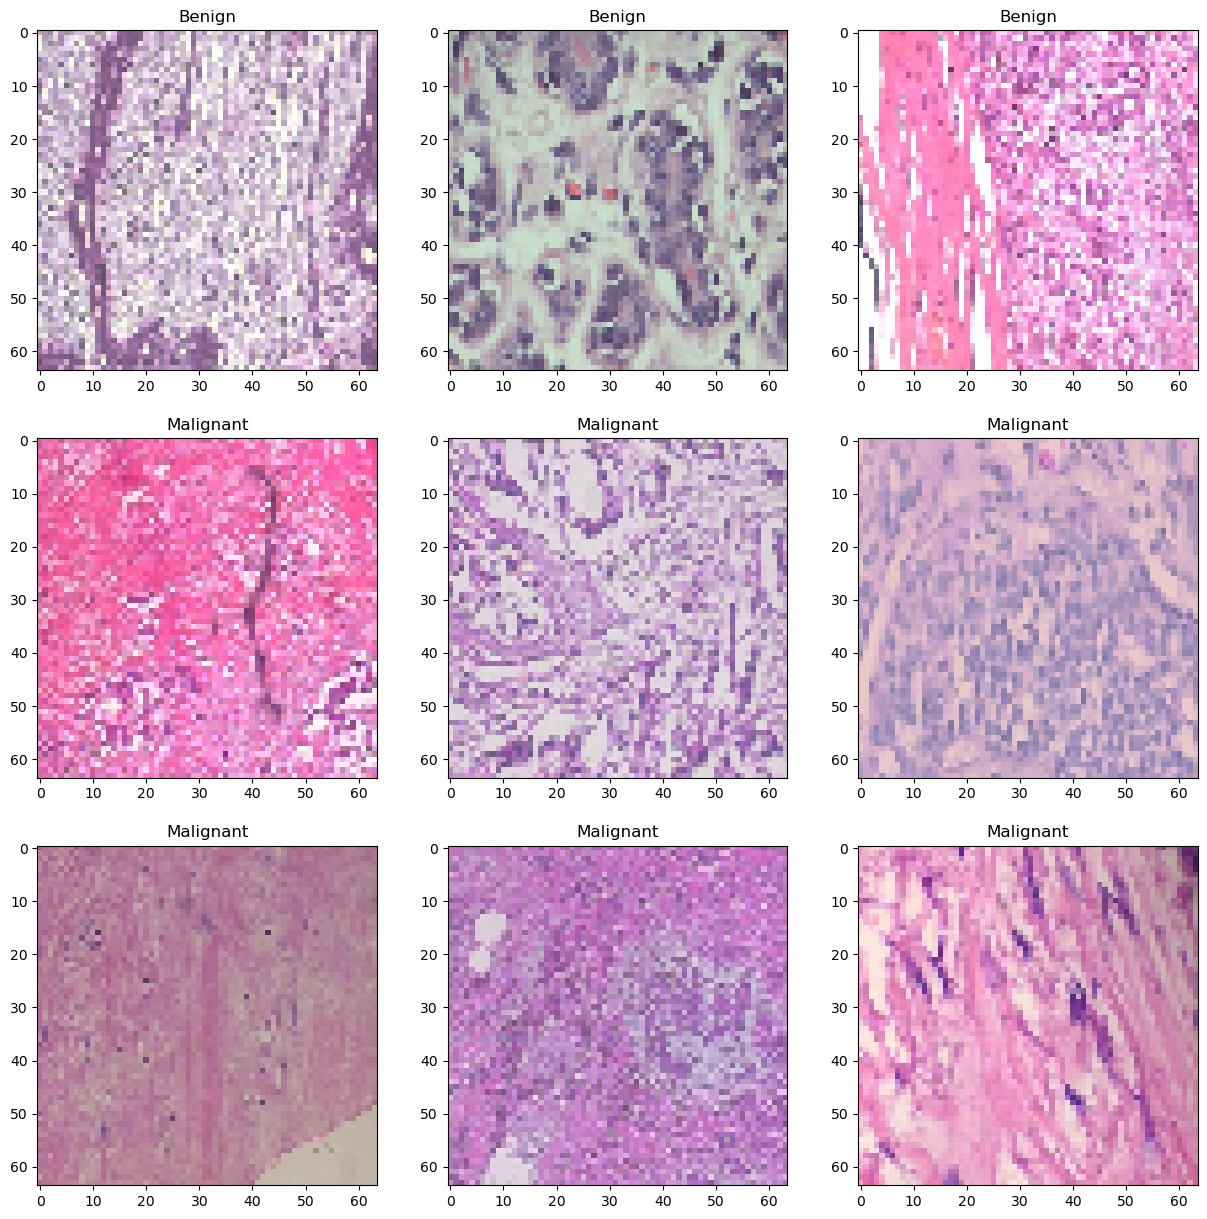

In [85]:
# Visualize sample images
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset.take(9)):
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

In [87]:
from tensorflow.keras.applications import VGG16

In [89]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [131]:
model.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,405 (6.01 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,049,604 (4.00 MB)

In [91]:
X_train_features = []
y_train_labels = []
for img, label in X_trainset:
    features = base_model.predict(img)
    X_train_features.append(features)
    y_train_labels.extend(label.numpy())

X_train_features = np.concatenate(X_train_features, axis=0)
y_train_labels = np.array(y_train_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

2024-07-09 23:38:20.759802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


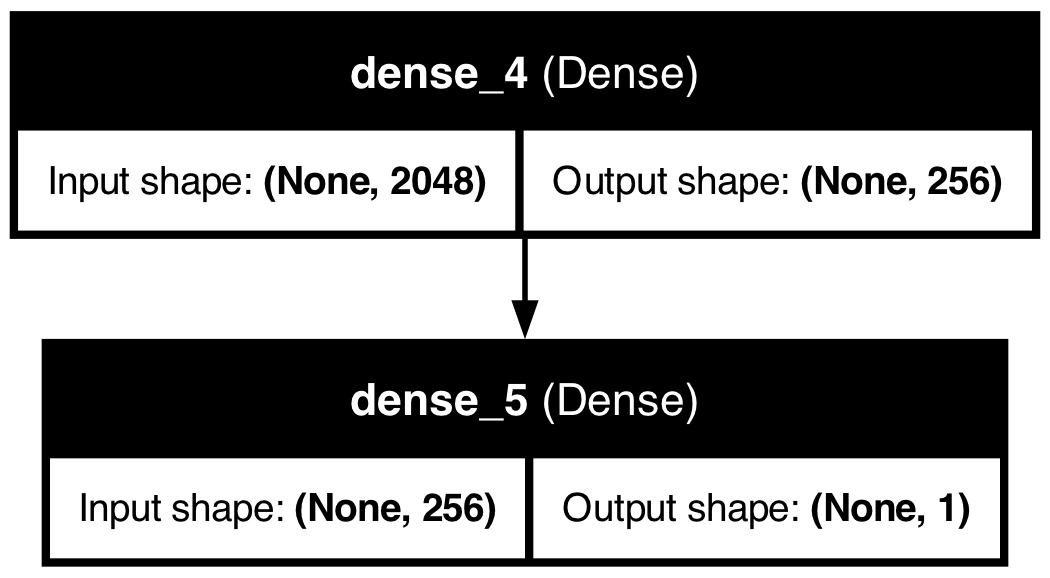

In [139]:
import os

# Ensure the PATH includes the directory where `dot` is located
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'

from tensorflow.keras.utils import plot_model

# Assuming 'model' is already defined
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [92]:
X_test_features = []
y_test_labels = []
for img, label in X_testset:
    features = base_model.predict(img)
    X_test_features.append(features)
    y_test_labels.extend(label.numpy())

X_test_features = np.concatenate(X_test_features, axis=0)
y_test_labels = np.array(y_test_labels)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


2024-07-09 23:38:34.479464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [95]:
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

In [97]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_features_flat, y_train_labels)


In [99]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Class distribution after oversampling:", dict(zip(unique, counts)))

Class distribution after oversampling: {0: 4357, 1: 4357}


In [101]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_features_flat = scaler.transform(X_test_features_flat)


In [105]:
# Build and compile the classification model
model = Sequential([
    Input(shape=(X_train_resampled.shape[1],)),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [107]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
EPOCHS = 100
history = model.fit(X_train_resampled, y_train_resampled, epochs=EPOCHS, validation_data=(X_test_features_flat, y_test_labels))

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7626 - loss: 0.6157 - val_accuracy: 0.8173 - val_loss: 0.5268
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8871 - loss: 0.2851 - val_accuracy: 0.8300 - val_loss: 0.5761
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.1828 - val_accuracy: 0.8357 - val_loss: 0.6255
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1327 - val_accuracy: 0.8426 - val_loss: 0.6958
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.1260 - val_accuracy: 0.8268 - val_loss: 0.9526
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9630 - loss: 0.1097 - val_accuracy: 0.8306 - val_loss: 0.9609
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.1047 - val_accuracy: 0.8388 - val_loss: 1.0668
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0615 - val_accu

In [111]:
loss, accuracy = model.evaluate(X_test_features_flat, y_test_labels)
print(f"Test Accuracy: {accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8613 - loss: 3.7026
Test Accuracy: 0.8457648754119873


In [113]:
y_pred = model.predict(X_test_features_flat)
y_pred = (y_pred > 0.5).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


In [115]:
print(f"Predicted labels: {np.unique(y_pred, return_counts=True)}")
print(f"True labels: {np.unique(y_test_labels, return_counts=True)}")

Predicted labels: (array([0, 1]), array([ 464, 1118]))
True labels: (array([0, 1]), array([ 510, 1072]))


In [117]:
print(classification_report(y_test_labels, y_pred))
conf_mat = confusion_matrix(y_test_labels, y_pred)
print("Confusion Matrix:\n", conf_mat)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       510
           1       0.87      0.91      0.89      1072

    accuracy                           0.85      1582
   macro avg       0.83      0.81      0.82      1582
weighted avg       0.84      0.85      0.84      1582

Confusion Matrix:
 [[365 145]
 [ 99 973]]


In [121]:
from sklearn.metrics import roc_curve, auc

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


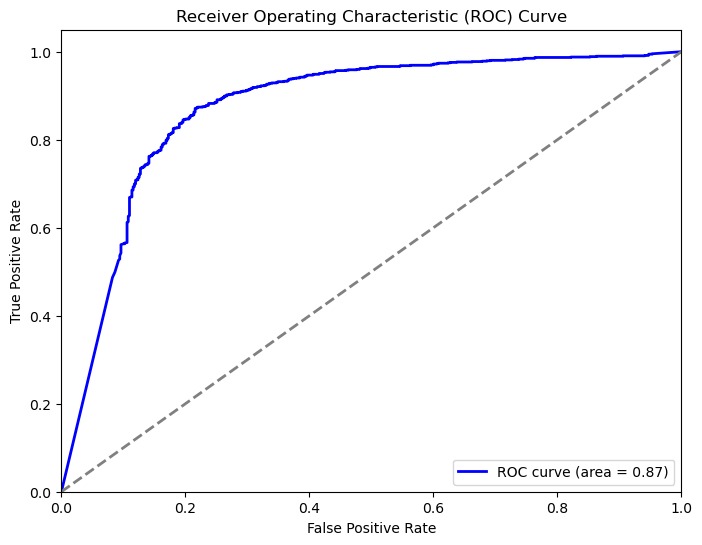

In [123]:
fpr, tpr, thresholds = roc_curve(y_test_labels, model.predict(X_test_features_flat))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

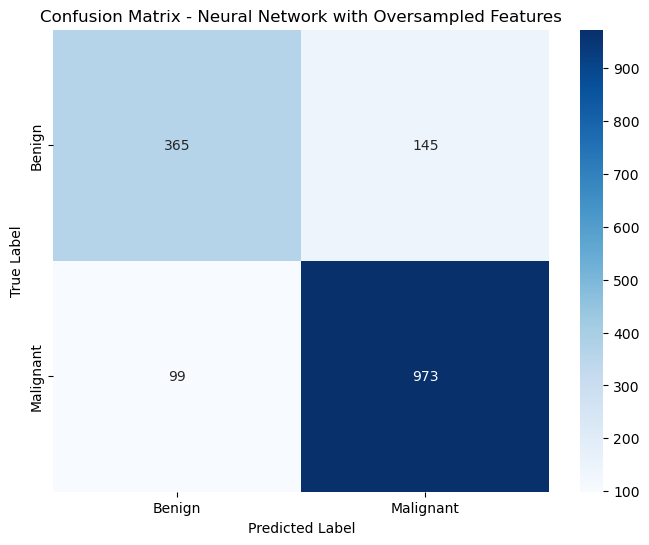

In [127]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Neural Network with Oversampled Features')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [129]:
model.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,405 (6.01 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,049,604 (4.00 MB)

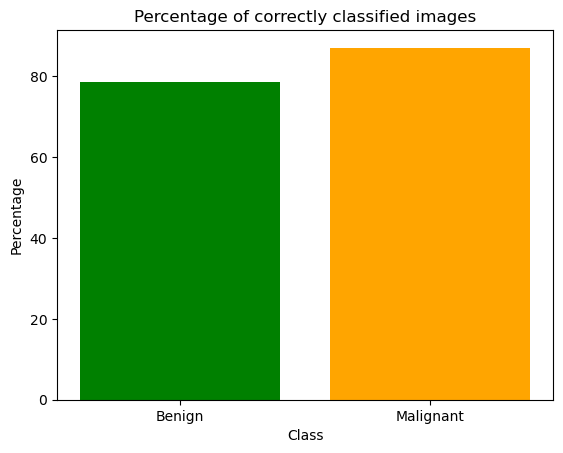

In [143]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)

Balancing the dataset using Data Augmentation

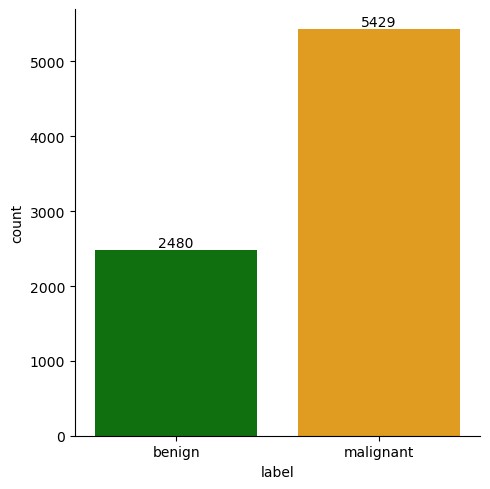

2024-07-17 21:53:07.411924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 3055 of 6327
2024-07-17 21:53:17.846632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-17 21:53:18.123247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


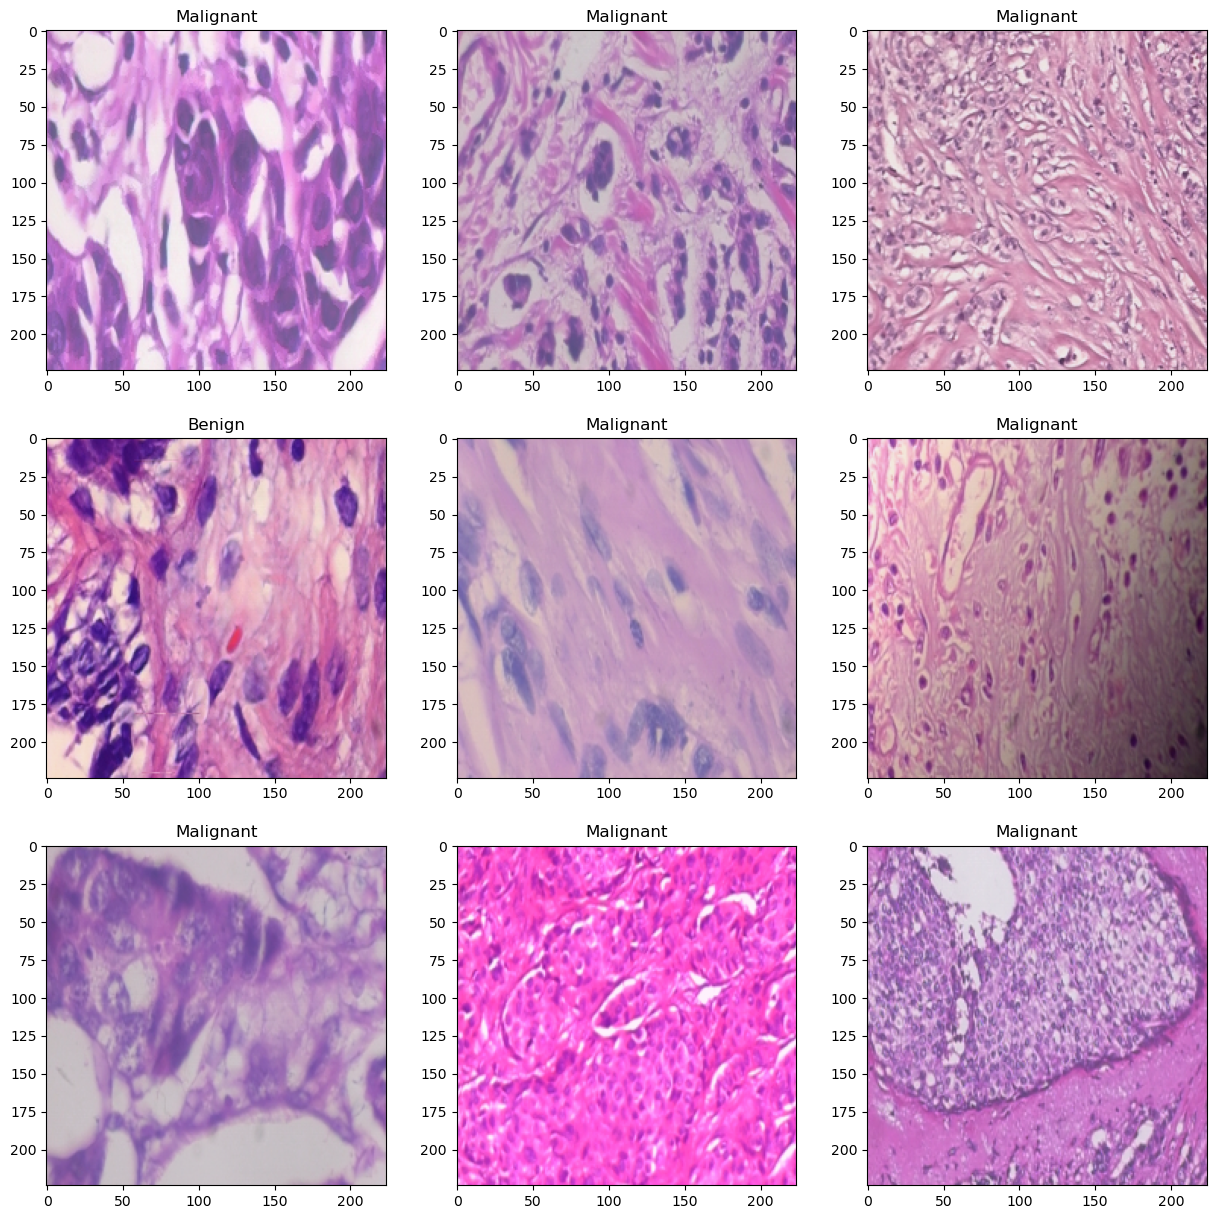

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,751,810 (56.27 MB)

 Trainable params: 37,122 (145.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/25


2024-07-17 21:53:29.657107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 3069 of 6327
2024-07-17 21:53:40.282383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 787s 8s/step - accuracy: 0.5311 - loss: 0.6885 - val_accuracy: 0.7718 - val_loss: 0.5187
Epoch 2/25


2024-07-17 22:06:35.684305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2782 of 6327
2024-07-17 22:06:48.421968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 873s 9s/step - accuracy: 0.7374 - loss: 0.5396 - val_accuracy: 0.8180 - val_loss: 0.4171
Epoch 3/25


2024-07-17 22:21:08.876026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2722 of 6327
2024-07-17 22:21:21.934412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 903s 9s/step - accuracy: 0.7797 - loss: 0.4734 - val_accuracy: 0.8085 - val_loss: 0.4338
Epoch 4/25


2024-07-17 22:36:12.362085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2693 of 6327
2024-07-17 22:36:25.779404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.8194 - loss: 0.4150 - val_accuracy: 0.8527 - val_loss: 0.3614
Epoch 5/25


2024-07-17 22:51:30.125339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2682 of 6327
2024-07-17 22:51:40.126294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5410 of 6327
2024-07-17 22:51:43.628516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 948s 9s/step - accuracy: 0.8128 - loss: 0.4148 - val_accuracy: 0.8571 - val_loss: 0.3572
Epoch 6/25


2024-07-17 23:07:18.365801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2534 of 6327
2024-07-17 23:07:33.329303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 983s 10s/step - accuracy: 0.8324 - loss: 0.3838 - val_accuracy: 0.7497 - val_loss: 0.5073
Epoch 7/25


2024-07-17 23:23:40.874321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2569 of 6327
2024-07-17 23:23:55.290475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 987s 10s/step - accuracy: 0.8278 - loss: 0.3798 - val_accuracy: 0.8382 - val_loss: 0.3569
Epoch 8/25


2024-07-17 23:40:07.636496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2592 of 6327
2024-07-17 23:40:22.483462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 978s 10s/step - accuracy: 0.8341 - loss: 0.3695 - val_accuracy: 0.8710 - val_loss: 0.3278
Epoch 9/25


2024-07-17 23:56:25.492676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2602 of 6327
2024-07-17 23:56:35.496365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5225 of 6327
2024-07-17 23:56:39.748950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 972s 10s/step - accuracy: 0.8380 - loss: 0.3715 - val_accuracy: 0.8578 - val_loss: 0.3419
Epoch 10/25


2024-07-18 00:12:37.176549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2576 of 6327
2024-07-18 00:12:47.177228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5200 of 6327
2024-07-18 00:12:51.402359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 968s 10s/step - accuracy: 0.8414 - loss: 0.3575 - val_accuracy: 0.8660 - val_loss: 0.3257
Epoch 11/25


2024-07-18 00:28:45.086957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2576 of 6327
2024-07-18 00:28:55.088124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5240 of 6327
2024-07-18 00:28:59.154126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 973s 10s/step - accuracy: 0.8387 - loss: 0.3627 - val_accuracy: 0.8723 - val_loss: 0.3109
Epoch 12/25


2024-07-18 00:44:58.530182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2608 of 6327
2024-07-18 00:45:08.532320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5202 of 6327
2024-07-18 00:45:12.816900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 996s 10s/step - accuracy: 0.8481 - loss: 0.3478 - val_accuracy: 0.8597 - val_loss: 0.3240
Epoch 13/25


2024-07-18 01:01:34.667959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2576 of 6327
2024-07-18 01:01:44.671030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5261 of 6327
2024-07-18 01:01:48.868738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 982s 10s/step - accuracy: 0.8543 - loss: 0.3304 - val_accuracy: 0.8375 - val_loss: 0.3595
Epoch 14/25


2024-07-18 01:17:56.347428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2559 of 6327
2024-07-18 01:18:10.948673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 970s 10s/step - accuracy: 0.8548 - loss: 0.3308 - val_accuracy: 0.8578 - val_loss: 0.3101
Epoch 15/25


2024-07-18 01:34:06.343580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2506 of 6327
2024-07-18 01:34:16.343749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5084 of 6327
2024-07-18 01:34:21.510182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 981s 10s/step - accuracy: 0.8563 - loss: 0.3257 - val_accuracy: 0.8831 - val_loss: 0.2948
Epoch 16/25


2024-07-18 01:50:27.531809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2580 of 6327
2024-07-18 01:50:37.532316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5197 of 6327
2024-07-18 01:50:41.746591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 960s 9s/step - accuracy: 0.8744 - loss: 0.2976 - val_accuracy: 0.8502 - val_loss: 0.3460
Epoch 17/25


2024-07-18 02:06:27.252367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2425 of 6327
2024-07-18 02:06:43.207336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 962s 9s/step - accuracy: 0.8679 - loss: 0.3060 - val_accuracy: 0.8793 - val_loss: 0.2937
Epoch 18/25


2024-07-18 02:22:29.293696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2622 of 6327
2024-07-18 02:22:39.295891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5285 of 6327
2024-07-18 02:22:43.100139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 955s 9s/step - accuracy: 0.8741 - loss: 0.2948 - val_accuracy: 0.8850 - val_loss: 0.2830
Epoch 19/25


2024-07-18 02:38:24.656029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2594 of 6327
2024-07-18 02:38:34.658177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 5264 of 6327
2024-07-18 02:38:38.803004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 946s 9s/step - accuracy: 0.8659 - loss: 0.3164 - val_accuracy: 0.8799 - val_loss: 0.2820
Epoch 20/25


2024-07-18 02:54:10.520307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2644 of 6327
2024-07-18 02:54:24.278940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 931s 9s/step - accuracy: 0.8731 - loss: 0.2834 - val_accuracy: 0.8919 - val_loss: 0.2789
Epoch 21/25


2024-07-18 03:09:41.698063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2676 of 6327
2024-07-18 03:09:55.119054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 906s 9s/step - accuracy: 0.8758 - loss: 0.2913 - val_accuracy: 0.7522 - val_loss: 0.5131
Epoch 22/25


2024-07-18 03:24:47.513700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2732 of 6327
2024-07-18 03:25:00.313981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 884s 9s/step - accuracy: 0.8667 - loss: 0.2919 - val_accuracy: 0.8710 - val_loss: 0.2989
Epoch 23/25


2024-07-18 03:39:31.844171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2696 of 6327
2024-07-18 03:39:44.945698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 904s 9s/step - accuracy: 0.8740 - loss: 0.2827 - val_accuracy: 0.8906 - val_loss: 0.2747
Epoch 24/25


2024-07-18 03:54:35.595587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2691 of 6327
2024-07-18 03:54:49.008778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 950s 9s/step - accuracy: 0.8922 - loss: 0.2535 - val_accuracy: 0.8913 - val_loss: 0.2632
Epoch 25/25


2024-07-18 04:10:25.107968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:59: Filling up shuffle buffer (this may take a while): 2652 of 6327
2024-07-18 04:10:39.509337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 932s 9s/step - accuracy: 0.8811 - loss: 0.2744 - val_accuracy: 0.8894 - val_loss: 0.2821
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.8954 - loss: 0.2628


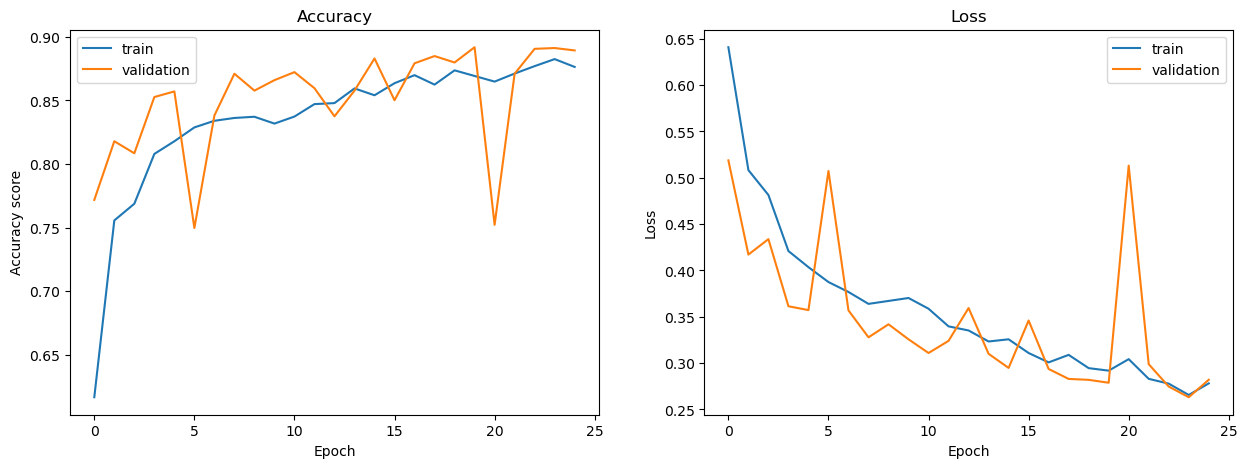

25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step
              precision    recall  f1-score   support

      Benign       0.85      0.80      0.83       510
   Malignant       0.91      0.93      0.92      1072

    accuracy                           0.89      1582
   macro avg       0.88      0.87      0.87      1582
weighted avg       0.89      0.89      0.89      1582



2024-07-18 04:31:45.352805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


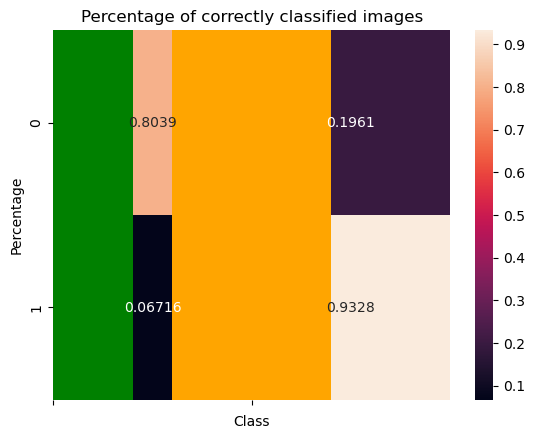

In [15]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import backend as K
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, losses, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

# Load data from the CSV file
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])

# Process the DataFrame
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()

# Plotting counts of labels
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

# Encode labels as integers
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

# Creating TensorFlow datasets
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [224, 224]) / 255.0  # VGG16 expects 224x224 input size
    return img, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

# Apply augmentation to the training dataset
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

# Display sample images
fig = plt.figure(figsize=(15, 15))
for images, labels in X_trainset.take(1):
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1)
        if labels.numpy()[i] == 0:
            ax.title.set_text("Benign")
        else:
            ax.title.set_text("Malignant")
        plt.imshow(images.numpy()[i])
plt.show()

# Define the model using VGG16
input_shape = (224, 224, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, 224, 224, 3))  # Ensure the model is built before calling summary
model.summary()

# Function to plot training history
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)
